In [1]:
import json
import os
import math

import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, XLNetTokenizer, XLNetModel, XLNetLMHeadModel, XLNetConfig, WarmupLinearSchedule
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
print("GPU Available: {}".format(torch.cuda.is_available()))
n_gpu = torch.cuda.device_count()
print("Number of GPU Available: {}".format(n_gpu))
print("GPU: {}".format(torch.cuda.get_device_name(0)))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GPU Available: True
Number of GPU Available: 4
GPU: Tesla V100-SXM2-32GB


In [3]:
df = pd.read_pickle("../data/fd_vn_physical_with_tokens_and_pooled_output.pkl")

In [4]:
df.head()

,cc,sentence,syntax,fd,tokens,tokens_pt,tokens_ids,token_wise_output,pooled_output
0,"[{'text': 'cart', 'q_value': '+MER', 'index': ...",The grocery cart hit against the wall,Sbj V PathP,Autonomous Place,"[the, grocery, cart, hit, against, the, wall]","[[tensor(101), tensor(1996), tensor(13025), te...","[1996, 13025, 11122, 2718, 2114, 1996, 2813]","[[[tensor(-0.2603), tensor(0.5590), tensor(-0....","[[tensor(-0.8683), tensor(-0.2977), tensor(-0...."
1,"[{'text': 'type', 'q_value': '+MER', 'index': ...",That type of rope coiled easily around the post,Sbj V PathP,Autonomous Place,"[that, type, of, rope, coiled, easily, around,...","[[tensor(101), tensor(2008), tensor(2828), ten...","[2008, 2828, 1997, 8164, 24599, 4089, 2105, 19...","[[[tensor(-0.1397), tensor(-0.2141), tensor(0....","[[tensor(-0.7615), tensor(-0.0670), tensor(0.1..."
2,"[{'text': 'rope', 'q_value': '+MER', 'index': ...",The rope coiled around the post,Sbj V PathP,Autonomous Place,"[the, rope, coiled, around, the, post]","[[tensor(101), tensor(1996), tensor(8164), ten...","[1996, 8164, 24599, 2105, 1996, 2695]","[[[tensor(-0.0777), tensor(0.0408), tensor(0.1...","[[tensor(-0.6512), tensor(-0.0065), tensor(0.7..."
3,"[{'text': 'company', 'q_value': '+MER', 'index...",The company is wedging into new markets,Sbj V PathP,Autonomous Place,"[the, company, is, wed, ##ging, into, new, mar...","[[tensor(101), tensor(1996), tensor(2194), ten...","[1996, 2194, 2003, 21981, 4726, 2046, 2047, 6089]","[[[tensor(0.0615), tensor(0.1368), tensor(0.30...","[[tensor(-0.8246), tensor(-0.1659), tensor(0.2..."
4,"[{'text': 'computer', 'q_value': '+MER', 'inde...",The computer connected well to the network,Sbj V PathP,Autonomous Place,"[the, computer, connected, well, to, the, netw...","[[tensor(101), tensor(1996), tensor(3274), ten...","[1996, 3274, 4198, 2092, 2000, 1996, 2897]","[[[tensor(-0.0860), tensor(-0.0513), tensor(0....","[[tensor(-0.6017), tensor(-0.1227), tensor(0.6..."


In [5]:
df.iloc[0].cc

[{'text': 'cart',
  'q_value': '+MER',
  'index': 3,
  'fd_subsequent': 7,
  'fd_relation': 'PTH'},
 {'text': 'wall', 'q_value': 'EXIST', 'index': 7, 'fd_relation': 'None'}]

In [6]:
def get_all_unique_q_values(df):
    all_q_values = []
    all_ccs = df.cc
    for cc in all_ccs:
        for token_bundle in cc:
            q_value = token_bundle["q_value"]
            if q_value == "DES**INTL":
                q_value = "INTL"
            if q_value == "":
                q_value = "MOT"
            if q_value not in all_q_values:
                all_q_values.append(q_value)
                
    return sorted(all_q_values)
    
    
all_q_values = get_all_unique_q_values(df)
all_q_values

['+MER',
 '-MER',
 'COS',
 'DES',
 'EXIST',
 'INTL',
 'MOT',
 'MPROP',
 'VOL',
 'VOL::+MER',
 'VOL::INTL',
 'VOL::MOT']

In [7]:
def make_df_for_train(df):

    all_items = []

    for idx, row in df.iterrows(): 

        cc = row.cc

        for c in cc:
            entity = c["text"] 
            sentence = row.sentence
            #sentence = sentence + " [SEP] " + entity + " [SEP] [CLS]"

            #sentence = sentence + " [SEP] " + entity + " [EOS] "
            
            sentence = sentence + " [SEP] " + entity

            item = {"sentence":sentence,'+MER': 0, '-MER':0, 'COS':0, 'DES':0, 'EXIST':0, 
                                        'INTL':0, 'MOT':0, 'MPROP':0, 'VOL': 0}

            q_value = c["q_value"]

            if q_value == "":
                item["MOT"] = 1
            elif "**" in q_value:
                item["INTL"] = 1
            elif "::" in q_value:
                q_values = c["q_value"].split("::")
                for q in q_values:
                    item[q] = 1
            else:
                item[q_value] = 1
            all_items.append(item)
    
    return pd.DataFrame(all_items)

df1 = make_df_for_train(df)

In [8]:
df1.iloc[0:20]

,sentence,+MER,-MER,COS,DES,EXIST,INTL,MOT,MPROP,VOL
0,The grocery cart hit against the wall [SEP] cart,1,0,0,0,0,0,0,0,0
1,The grocery cart hit against the wall [SEP] wall,0,0,0,0,1,0,0,0,0
2,That type of rope coiled easily around the pos...,1,0,0,0,0,0,0,0,0
3,That type of rope coiled easily around the pos...,0,0,0,0,1,0,0,0,0
4,The rope coiled around the post [SEP] rope,1,0,0,0,0,0,0,0,0
5,The rope coiled around the post [SEP] post,0,0,0,0,1,0,0,0,0
6,The company is wedging into new markets [SEP] ...,1,0,0,0,0,0,0,0,0
7,The company is wedging into new markets [SEP] ...,0,0,0,0,1,0,0,0,0
8,The computer connected well to the network [SE...,1,0,0,0,0,0,0,0,0
9,The computer connected well to the network [SE...,0,0,0,0,1,0,0,0,0


In [9]:
json_infile_path = '../data/decomp_q_value_for_training.json'

with open(json_infile_path, 'r') as infile:
    decomp_data = json.load(infile)

def make_df_for_test(data):
    
    all_items = []
            
    for d in data:
        
        if d["type"] == "physical":
        
            entity = d["tgt_token"] 
            sentence = d["sentence"]
            #sentence = sentence + " [SEP] " + entity + " [SEP] [CLS]"

            #sentence = sentence + " [SEP] " + entity + " [EOS] "

            sentence = sentence + " [SEP] " + entity

            item = {"sentence":sentence,'+MER': 0, '-MER':0, 'COS':0, 'DES':0, 'EXIST':0, 
                                        'INTL':0, 'MOT':0, 'MPROP':0, 'VOL': 0, "property": d["property"]}

            q_value = d["property"]

            if "::" in q_value:
                q_values = q_value.split("::")
                for q in q_values:
                    item[q] = 1
            else:
                item[q_value] = 1
            all_items.append(item)
        
    return pd.DataFrame(all_items)
    
df_test = make_df_for_test(decomp_data)

In [10]:
#train, test = train_test_split(df1, test_size=0.0)
train = df1.copy(deep=True)
test = df_test.copy(deep=True)

In [11]:
train.shape

(1257, 10)

In [12]:
test.shape

(235, 11)

/nfs/student/r/regan/anaconda3/envs/torch2/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  if sys.path[0] == '':


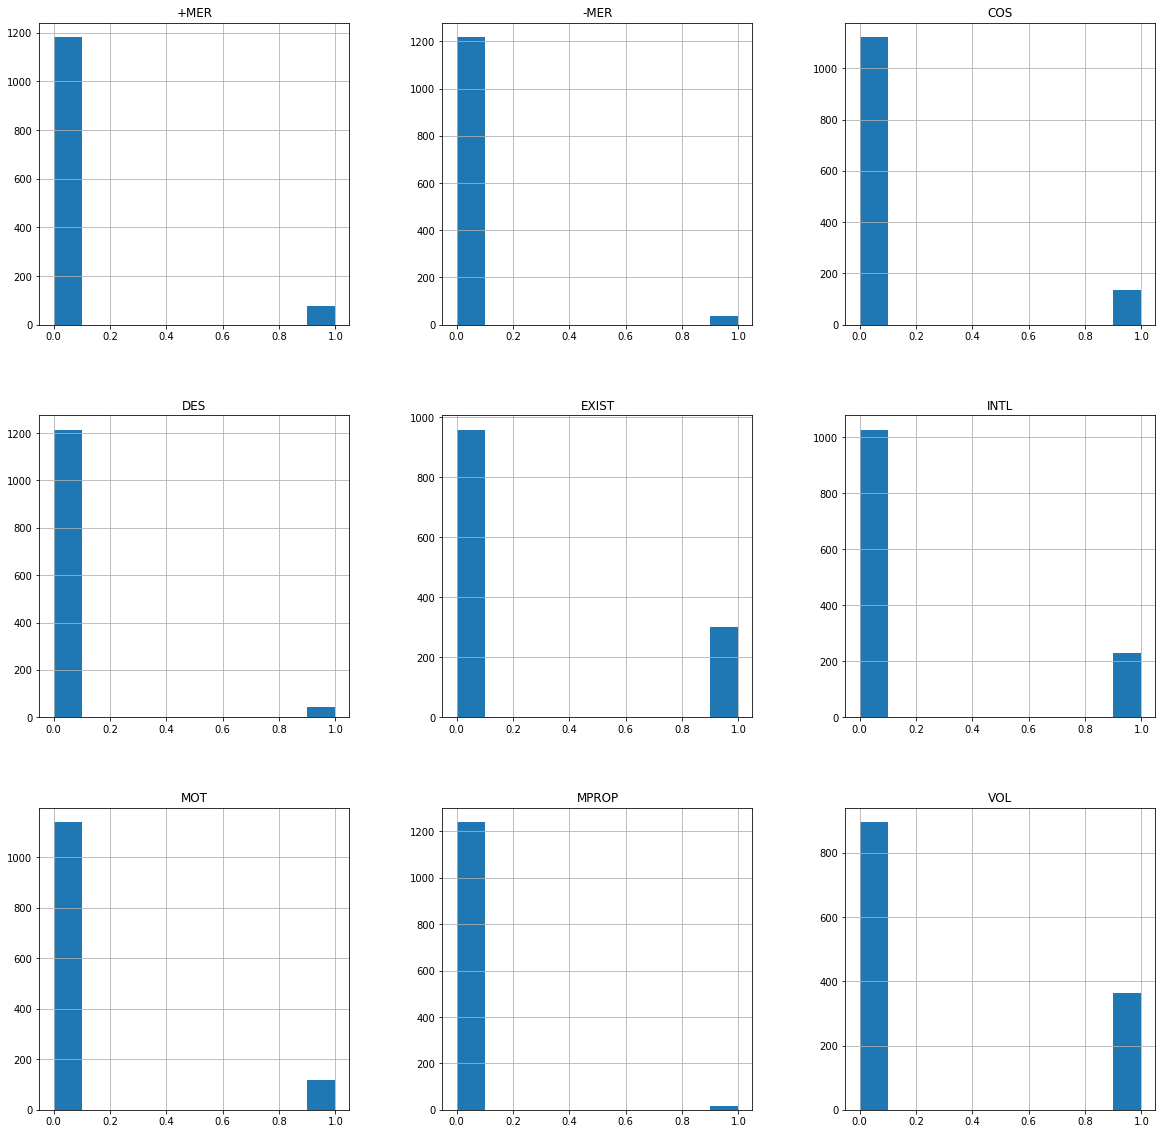

In [13]:
label_cols = ['+MER',
 '-MER',
 'COS',
 'DES',
 'EXIST',
 'INTL',
 'MOT',
 'MPROP',
 'VOL']

fig, ax = plt.subplots(figsize=(20, 20));
train[label_cols].hist(ax=ax);

In [14]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

In [15]:
train_text_list = train["sentence"].values
test_text_list = test["sentence"].values

In [16]:
def tokenize_inputs(text_list, tokenizer, num_embeddings=512):
    """
    Tokenizes the input text input into ids. Appends the appropriate special
    characters to the end of the text to denote end of sentence. Truncate or pad
    the appropriate sequence length.
    """
    # tokenize the text, then truncate sequence to the desired length minus 2 for
    # the 2 special characters
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:num_embeddings-2], text_list))
    # convert tokenized text into numeric ids for the appropriate LM
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    # append special token "<s>" and </s> to end of sentence
    input_ids = [tokenizer.build_inputs_with_special_tokens(x) for x in input_ids]
    # pad sequences
    input_ids = pad_sequences(input_ids, maxlen=num_embeddings, dtype="long", truncating="post", padding="post")
    return input_ids

def create_attn_masks(input_ids):
    """
    Create attention masks to tell model whether attention should be applied to
    the input id tokens. Do not want to perform attention on padding tokens.
    """
    # Create attention masks
    attention_masks = []

    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return attention_masks

In [17]:
train_input_ids = tokenize_inputs(train_text_list, tokenizer, num_embeddings=20)
train_input_ids.shape

(1257, 20)

In [18]:
# create input id tokens
test_input_ids = tokenize_inputs(test_text_list, tokenizer, num_embeddings=20)

In [19]:
# create attention masks
train_attention_masks = create_attn_masks(train_input_ids)
test_attention_masks = create_attn_masks(test_input_ids)

In [20]:
# add input ids and attention masks to the dataframe
train["features"] = train_input_ids.tolist()
train["masks"] = train_attention_masks

test["features"] = test_input_ids.tolist()
test["masks"] = test_attention_masks

In [21]:
train.head()

,sentence,+MER,-MER,COS,DES,EXIST,INTL,MOT,MPROP,VOL,features,masks
0,The grocery cart hit against the wall [SEP] cart,1,0,0,0,0,0,0,0,0,"[18, 12166, 7930, 645, 157, 18, 1759, 4145, 23...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,The grocery cart hit against the wall [SEP] wall,0,0,0,0,1,0,0,0,0,"[18, 12166, 7930, 645, 157, 18, 1759, 4145, 23...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,That type of rope coiled easily around the pos...,1,0,0,0,0,0,0,0,0,"[29, 1037, 20, 8699, 2349, 19091, 1659, 199, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,That type of rope coiled easily around the pos...,0,0,0,0,1,0,0,0,0,"[29, 1037, 20, 8699, 2349, 19091, 1659, 199, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,The rope coiled around the post [SEP] rope,1,0,0,0,0,0,0,0,0,"[18, 8699, 2349, 19091, 199, 18, 701, 4145, 23...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [22]:
test.head()

,sentence,+MER,-MER,COS,DES,EXIST,INTL,MOT,MPROP,VOL,property,features,masks
0,Employees wore identification badges listing n...,0,0,0,0,0,0,0,0,1,VOL,"[1616, 5811, 7850, 13832, 23, 5867, 50, 114, 5...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,Employees wore identification badges listing n...,0,0,0,0,1,0,0,0,0,EXIST,"[1616, 5811, 7850, 13832, 23, 5867, 50, 114, 5...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,"It runs out frantically now and then, and is c...",0,0,0,0,0,0,0,0,1,VOL,"[36, 1517, 78, 26491, 145, 21, 137, 19, 21, 27...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,Dr. Kobayashi responded that he thought the an...,0,0,1,0,0,0,0,0,0,COS,"[17, 7841, 9, 17, 1507, 8986, 12753, 4541, 29,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,Dr. Kobayashi responded that he thought the an...,0,0,0,0,0,1,0,0,0,INTL,"[17, 7841, 9, 17, 1507, 8986, 12753, 4541, 29,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [23]:
# train valid split
train, valid = train_test_split(train, test_size=0.05, random_state=42)
train = train.copy(deep=True)
valid = valid.copy(deep=True)

In [24]:
X_train = train["features"].values.tolist()
X_valid = valid["features"].values.tolist()

train_masks = train["masks"].values.tolist()
valid_masks = valid["masks"].values.tolist()

Y_train = train[label_cols].values.tolist()
Y_valid = valid[label_cols].values.tolist()

In [25]:
# Convert all of our input ids and attention masks into 
# torch tensors, the required datatype for our model

X_train = torch.tensor(X_train)
X_valid = torch.tensor(X_valid)

Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_valid = torch.tensor(Y_valid, dtype=torch.float32)

train_masks = torch.tensor(train_masks, dtype=torch.long)
valid_masks = torch.tensor(valid_masks, dtype=torch.long)

In [26]:
# Select a batch size for training
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on 
# memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(X_train, train_masks, Y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,\
                              sampler=train_sampler,\
                              batch_size=batch_size)

validation_data = TensorDataset(X_valid, valid_masks, Y_valid)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,\
                                   sampler=validation_sampler,\
                                   batch_size=batch_size)

In [27]:
def train(model, num_epochs,\
          optimizer,\
          train_dataloader, valid_dataloader,\
          model_save_path,\
          train_loss_set=[], valid_loss_set = [],\
          lowest_eval_loss=None, start_epoch=0,\
          device="cpu"
          ):
  """
  Train the model and save the model with the lowest validation loss
  """

  model.to(device)

  # trange is a tqdm wrapper around the normal python range
  for i in trange(num_epochs, desc="Epoch"):
    # if continue training from saved model
    actual_epoch = start_epoch + i

    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0
    num_train_samples = 0

    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Clear out the gradients (by default they accumulate)
      optimizer.zero_grad()
      # Forward pass
      loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
      # store train loss
      tr_loss += loss.item()
      num_train_samples += b_labels.size(0)
      # Backward pass
      loss.backward()
      # Update parameters and take a step using the computed gradient
      optimizer.step()
      scheduler.step()

    # Update tracking variables
    epoch_train_loss = tr_loss/num_train_samples
    train_loss_set.append(epoch_train_loss)

    print("Train loss: {}".format(epoch_train_loss))

    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Tracking variables 
    eval_loss = 0
    num_eval_samples = 0

    # Evaluate data for one epoch
    for batch in valid_dataloader:
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Telling the model not to compute or store gradients,
      # saving memory and speeding up validation
      with torch.no_grad():
        # Forward pass, calculate validation loss
        loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        # store valid loss
        eval_loss += loss.item()
        num_eval_samples += b_labels.size(0)

    epoch_eval_loss = eval_loss/num_eval_samples
    valid_loss_set.append(epoch_eval_loss)

    print("Valid loss: {}".format(epoch_eval_loss))

    if lowest_eval_loss == None:
      lowest_eval_loss = epoch_eval_loss
      # save model
      save_model(model, model_save_path, actual_epoch,\
                 lowest_eval_loss, train_loss_set, valid_loss_set)
    else:
      if epoch_eval_loss < lowest_eval_loss:
        lowest_eval_loss = epoch_eval_loss
        # save model
        save_model(model, model_save_path, actual_epoch,\
                   lowest_eval_loss, train_loss_set, valid_loss_set)
    print("\n")

  return model, train_loss_set, valid_loss_set


def save_model(model, save_path, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist):
  """
  Save the model to the path directory provided
  """
  model_to_save = model.module if hasattr(model, 'module') else model
  checkpoint = {'epochs': epochs, \
                'lowest_eval_loss': lowest_eval_loss,\
                'state_dict': model_to_save.state_dict(),\
                'train_loss_hist': train_loss_hist,\
                'valid_loss_hist': valid_loss_hist
               }
  torch.save(checkpoint, save_path)
  print("Saving model at epoch {} with validation loss of {}".format(epochs,\
                                                                     lowest_eval_loss))
  return
  
def load_model(save_path):
  """
  Load the model from the path directory provided
  """
  checkpoint = torch.load(save_path)
  model_state_dict = checkpoint['state_dict']
  model = XLNetForMultiLabelSequenceClassification(num_labels=model_state_dict["classifier.weight"].size()[0])
  model.load_state_dict(model_state_dict)

  epochs = checkpoint["epochs"]
  lowest_eval_loss = checkpoint["lowest_eval_loss"]
  train_loss_hist = checkpoint["train_loss_hist"]
  valid_loss_hist = checkpoint["valid_loss_hist"]
  
  return model, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist

In [28]:
torch.cuda.empty_cache()

In [29]:
class XLNetForMultiLabelSequenceClassification(torch.nn.Module):
  
  def __init__(self, num_labels=2):
    super(XLNetForMultiLabelSequenceClassification, self).__init__()
    self.num_labels = num_labels
    self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased')
    self.classifier = torch.nn.Linear(768, num_labels)
    #self.classifier = torch.nn.Linear(1024, num_labels)
    
    torch.nn.init.xavier_normal_(self.classifier.weight)

  def forward(self, input_ids, token_type_ids=None,\
              attention_mask=None, labels=None):
    # last hidden layer
    last_hidden_state = self.xlnet(input_ids=input_ids,\
                                   attention_mask=attention_mask,\
                                   token_type_ids=token_type_ids)
    # pool the outputs into a mean vector
    mean_last_hidden_state = self.pool_hidden_state(last_hidden_state)
    logits = self.classifier(mean_last_hidden_state)
        
    if labels is not None:
      loss_fct = BCEWithLogitsLoss()
      loss = loss_fct(logits.view(-1, self.num_labels),\
                      labels.view(-1, self.num_labels))
      return loss
    else:
      return logits
    
  def freeze_xlnet_decoder(self):
    """
    Freeze XLNet weight parameters. They will not be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = False
    
  def unfreeze_xlnet_decoder(self):
    """
    Unfreeze XLNet weight parameters. They will be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = True
    
  def pool_hidden_state(self, last_hidden_state):
    """
    Pool the output vectors into a single mean vector 
    """
    last_hidden_state = last_hidden_state[0]
    mean_last_hidden_state = torch.mean(last_hidden_state, 1)
    return mean_last_hidden_state
    
model = XLNetForMultiLabelSequenceClassification(num_labels=len(Y_train[0]))

In [30]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)

num_epochs=12

num_warmup_steps = batch_size
num_total_steps = batch_size * num_epochs
scheduler = WarmupLinearSchedule(optimizer, warmup_steps=num_warmup_steps, t_total=num_total_steps)  # PyTorch scheduler


In [31]:
cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "/nfs/research/regan/src/data/models/xlnet_fd_q_value.bin")
model, train_loss_set, valid_loss_set = train(model=model,\
                                              num_epochs=num_epochs,\
                                              optimizer=optimizer,\
                                              train_dataloader=train_dataloader,\
                                              valid_dataloader=validation_dataloader,\
                                              model_save_path=model_save_path,\
                                              device="cuda")

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 0.01973102103226149
Valid loss: 0.009565236076476082


Epoch:  10%|█         | 1/10 [00:07<01:06,  7.37s/it]

Saving model at epoch 0 with validation loss of 0.009565236076476082


Train loss: 0.010212352577366022
Valid loss: 0.009304934077792697


Epoch:  20%|██        | 2/10 [00:14<00:58,  7.29s/it]

Saving model at epoch 1 with validation loss of 0.009304934077792697


Train loss: 0.009585046688316256
Valid loss: 0.008219900112303476


Epoch:  30%|███       | 3/10 [00:22<00:52,  7.48s/it]

Saving model at epoch 2 with validation loss of 0.008219900112303476


Train loss: 0.008548445076099791
Valid loss: 0.006573431075565399


Epoch:  40%|████      | 4/10 [00:32<00:49,  8.25s/it]

Saving model at epoch 3 with validation loss of 0.006573431075565399


Train loss: 0.006883772461358427
Valid loss: 0.005699953626072596


Epoch:  50%|█████     | 5/10 [00:42<00:44,  8.84s/it]

Saving model at epoch 4 with validation loss of 0.005699953626072596


Train loss: 0.00596587175824734
Valid loss: 0.003977884021070268


Epoch:  60%|██████    | 6/10 [00:52<00:37,  9.28s/it]

Saving model at epoch 5 with validation loss of 0.003977884021070268




Epoch:  70%|███████   | 7/10 [00:58<00:24,  8.24s/it]

Train loss: 0.0049464191049586985
Valid loss: 0.0041735415893887715


Train loss: 0.004424072596146233
Valid loss: 0.0035234250956111485


Epoch:  80%|████████  | 8/10 [01:09<00:17,  8.87s/it]

Saving model at epoch 7 with validation loss of 0.0035234250956111485




Epoch:  90%|█████████ | 9/10 [01:15<00:07,  7.98s/it]

Train loss: 0.00400496576873701
Valid loss: 0.003648692180239965




Epoch: 100%|██████████| 10/10 [01:20<00:00,  8.10s/it]

Train loss: 0.004133160134006784
Valid loss: 0.003648692180239965




Text(0.5, 1.0, 'Loss vs Number of Epochs')

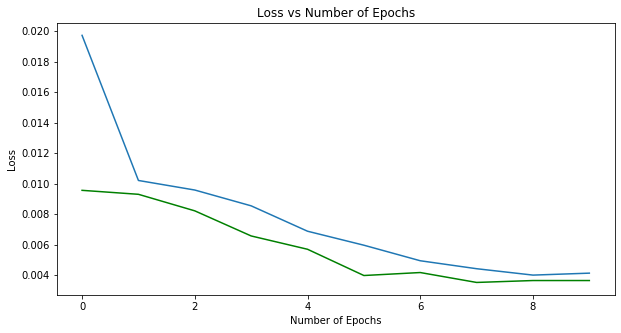

In [32]:
# Plot loss
num_epochs = np.arange(len(train_loss_set))

fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(train_loss_set), label="Train Loss")
ax.plot(num_epochs, np.array(valid_loss_set), 'g-', label="Valid Loss")
#ax1.plot(episode_record, lose_record, 'r-', label="Lose %")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Number of Epochs")

In [33]:
def generate_predictions(model, df, num_labels, device="cpu", batch_size=32):
  num_iter = math.ceil(df.shape[0]/batch_size)
  
  pred_probs = np.array([]).reshape(0, num_labels)
  
  model.to(device)
  model.eval()
  
  for i in range(num_iter):
    df_subset = df.iloc[i*batch_size:(i+1)*batch_size,:]
    X = df_subset["features"].values.tolist()
    masks = df_subset["masks"].values.tolist()
    X = torch.tensor(X)
    masks = torch.tensor(masks, dtype=torch.long)
    X = X.to(device)
    masks = masks.to(device)
    with torch.no_grad():
      logits = model(input_ids=X, attention_mask=masks)
      logits = logits.sigmoid().detach().cpu().numpy()
      pred_probs = np.vstack([pred_probs, logits])
  
  return pred_probs

In [34]:
num_labels = len(label_cols)
pred_probs = generate_predictions(model, test, num_labels, device="cuda", batch_size=32)
pred_probs

array([[0.01488585, 0.0161983 , 0.00890825, ..., 0.01313236, 0.00655542,
        0.06511439],
       [0.01488585, 0.0161983 , 0.00890825, ..., 0.01313236, 0.00655542,
        0.06511439],
       [0.00053737, 0.01372056, 0.00423968, ..., 0.00201643, 0.01193088,
        0.0015381 ],
       ...,
       [0.00352523, 0.01309014, 0.00554504, ..., 0.01964808, 0.01355207,
        0.00878297],
       [0.00089482, 0.00924782, 0.01400675, ..., 0.03395356, 0.02142402,
        0.03954076],
       [0.00362952, 0.05047083, 0.1719355 , ..., 0.00309374, 0.04753794,
        0.01297848]])

In [35]:
test

,sentence,+MER,-MER,COS,DES,EXIST,INTL,MOT,MPROP,VOL,property,features,masks
0,Employees wore identification badges listing n...,0,0,0,0,0,0,0,0,1,VOL,"[1616, 5811, 7850, 13832, 23, 5867, 50, 114, 5...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,Employees wore identification badges listing n...,0,0,0,0,1,0,0,0,0,EXIST,"[1616, 5811, 7850, 13832, 23, 5867, 50, 114, 5...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,"It runs out frantically now and then, and is c...",0,0,0,0,0,0,0,0,1,VOL,"[36, 1517, 78, 26491, 145, 21, 137, 19, 21, 27...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,Dr. Kobayashi responded that he thought the an...,0,0,1,0,0,0,0,0,0,COS,"[17, 7841, 9, 17, 1507, 8986, 12753, 4541, 29,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,Dr. Kobayashi responded that he thought the an...,0,0,0,0,0,1,0,0,0,INTL,"[17, 7841, 9, 17, 1507, 8986, 12753, 4541, 29,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,"He went back with the officers , gave them no ...",0,0,0,0,0,0,1,0,1,VOL::MOT,"[43, 388, 126, 33, 18, 1794, 17, 19, 675, 107,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
231,We did n't really get anywhere so he dropped m...,0,0,0,0,0,0,1,0,0,MOT,"[80, 190, 17, 180, 26, 46, 343, 133, 3905, 102...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
232,We did n't really get anywhere so he dropped m...,0,0,0,0,1,0,0,0,0,EXIST,"[80, 190, 17, 180, 26, 46, 343, 133, 3905, 102...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
233,When she came to visit in Italy after BabyD wa...,0,0,0,0,0,0,1,0,1,VOL::MOT,"[90, 85, 301, 22, 733, 25, 36, 12229, 99, 1997...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [36]:
label_cols = ['+MER',
 '-MER',
 'COS',
 'DES',
 'EXIST',
 'INTL',
 'MOT',
 'MPROP',
 'VOL']

In [37]:
test.columns.values

array(['sentence', '+MER', '-MER', 'COS', 'DES', 'EXIST', 'INTL', 'MOT',
       'MPROP', 'VOL', 'property', 'features', 'masks'], dtype=object)

In [ ]:
from operator import itemgetter 

all_predictions = []
for pred in pred_probs:
    one_max = np.argpartition(pred, -1)[-1:]
    two_max = np.argpartition(pred, -2)[-2:]
    #print(pred[one_max[0]], pred[one_max[0]] > .90)
    if pred[one_max[0]] > .15:
        prediction = one_max
        
    else:
        prediction = two_max
    all_predictions.append(prediction)
 
# test.columns.values


for idx, row in test.iterrows():
    b = all_predictions[idx]
    a = label_cols
    print(idx, row.sentence, itemgetter(*b)(a), df_test.iloc[idx]["property"])
    print()
    

In [45]:
all_predictions[0:10]

[array([5]),
 array([5]),
 array([4]),
 array([4]),
 array([4]),
 array([8]),
 array([5, 2]),
 array([8]),
 array([4]),
 array([4, 5])]

In [46]:
correct = 0
incorrect = 0
count_predictions = 0
for i in range(len(test)):

    target = test.iloc[i][["+MER", "-MER", "COS", "DES", "EXIST", "INTL", "MOT", "MPROP", "VOL"]].tolist()
    _p = all_predictions[i]
    
    for p in _p:
        #print(_p, target, target[p])
        count_predictions += 1
        if target[p] == 1:
            correct+=1
        else:
            incorrect += 1

accuracy = correct / count_predictions
print("Accuracy:", accuracy)
print("Incorrect:", incorrect)
print("Total predictions:", count_predictions)

Accuracy: 0.22304832713754646
Incorrect: 209
Total predictions: 269
